<a href="https://colab.research.google.com/github/harshit-k11/microservices-decomposer/blob/main/final_louvain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the desired number of microservices (or press Enter for automatic): 0
Louvain Communities:
Service 1: 
Nanoentities: 
Service 2: PostOrder, InstructOrder, viewPortfolio
Nanoentities: Order.type, Instruction.instructedTime, Order.executed, Order.amount, Position.balance, Order.posted, Order.expires, PaymentInfo.cashAccount
Service 3: ImportPrice
Nanoentities: Order.triggerPrice, Price.currency, Price.price, Price.dateTime
Service 4: ReadNews, ImportNews
Nanoentities: News.title, Stock.identifier, News.text, News.image
Service 5: View Recommendations, SuggestRecommendations
Nanoentities: Recommendation.description, Account.number, Stock.stockName
Service 6: CreateAccount, CreateAccountOwner
Nanoentities: NaturalPerson.name, Company.companyName, AccountOwner.address


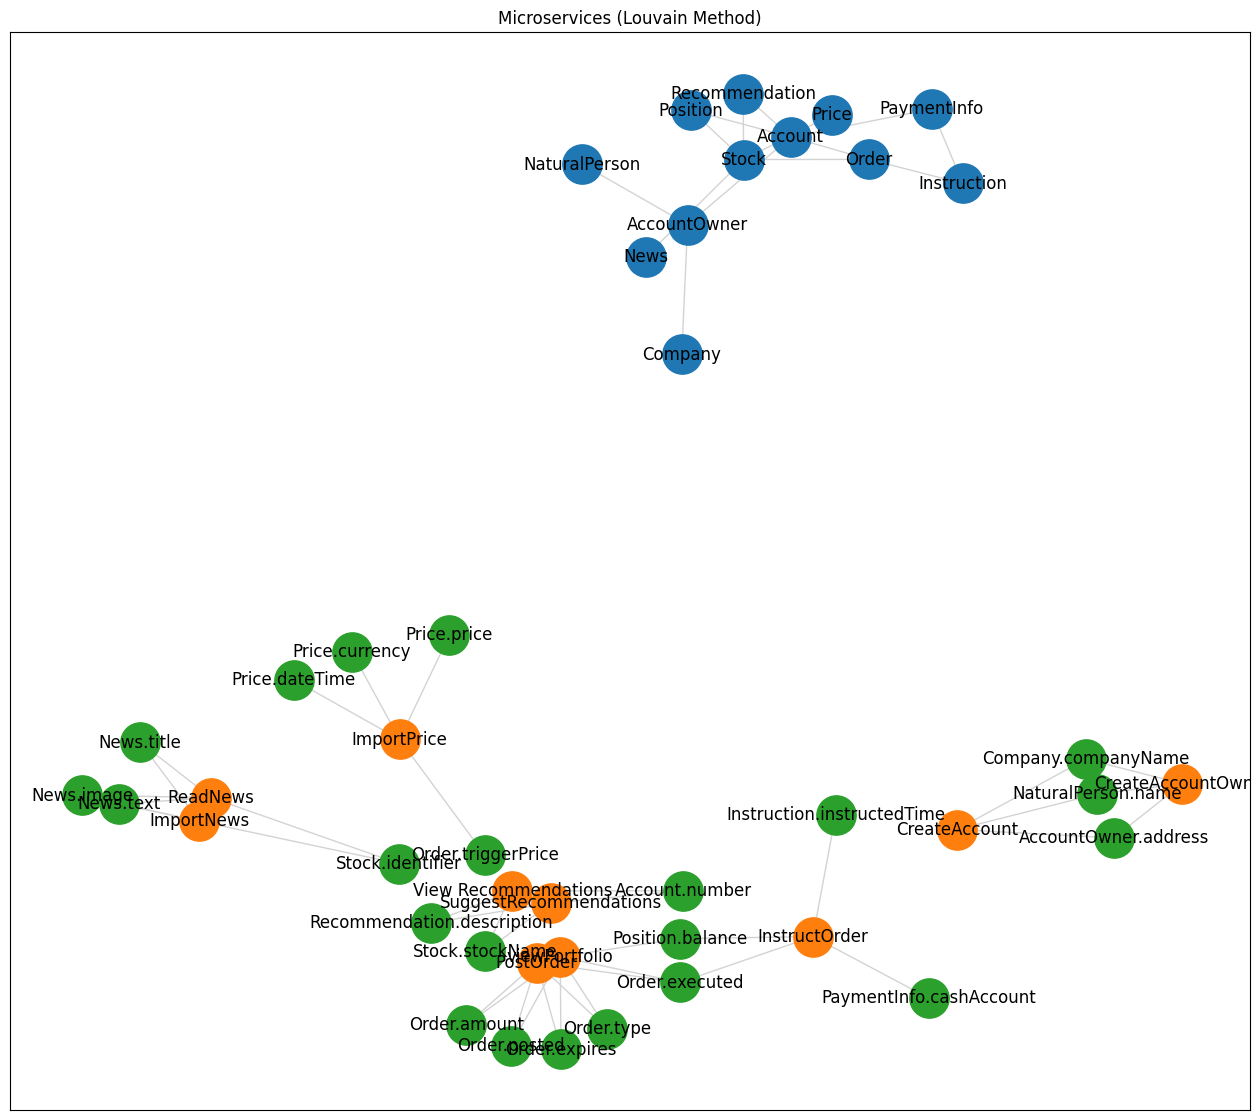

In [6]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # Importing the Louvain method
import uuid

class CommunityDetector:
    def __init__(self, user_model_file, user_representations_file):
        self.user_model = self.load_data(user_model_file)
        self.user_representations = self.load_data(user_representations_file)
        self.graph = self.create_graph()

    def load_data(self, file_path):
        with open(file_path, "r") as file:
            data = json.load(file)
        return data

    def create_graph(self):
        graph = nx.Graph()

        # Add entities as nodes
        for entity in self.user_model["entities"]:
            graph.add_node(entity["name"])

        # Add relations as edges
        for relation in self.user_model["relations"]:
            graph.add_edge(relation["origin"], relation["destination"])

        # Add use cases as nodes
        for use_case in self.user_representations["useCases"]:
            graph.add_node(use_case["name"])

        # Add nanoentities as nodes
        nanoentities = set()
        for use_case in self.user_representations["useCases"]:
            nanoentities.update(use_case["nanoentitiesRead"] + use_case["nanoentitiesWritten"])
        for nanoentity in nanoentities:
            graph.add_node(nanoentity)

        # Add edges between use cases and nanoentities
        for use_case in self.user_representations["useCases"]:
            for nanoentity in use_case["nanoentitiesRead"] + use_case["nanoentitiesWritten"]:
                graph.add_edge(use_case["name"], nanoentity)

        return graph

    def detect_communities(self, num_communities=None):
        partition = community_louvain.best_partition(self.graph)
        communities = {}
        for node, community in partition.items():
            communities.setdefault(community, []).append(node)
        return list(communities.values())

    def print_communities(self, communities):
        for i, community in enumerate(communities, start=1):
            business_functions = [node for node in community if node in [use_case["name"] for use_case in self.user_representations["useCases"]]]
            nanoentities = [node for node in community if node not in [entity["name"] for entity in self.user_model["entities"]] and node not in [use_case["name"] for use_case in self.user_representations["useCases"]]]
            print(f"Service {i}: {', '.join(business_functions)}")
            print(f"Nanoentities: {', '.join(nanoentities)}")
    def visualize_communities(self, communities):
        # Use spring layout for better node distribution
        pos = nx.spring_layout(self.graph, k=0.5, iterations=100)
        community_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        entity_color = 'tab:blue'
        use_case_color = 'tab:orange'
        nanoentity_color = 'tab:green'

        plt.figure(figsize=(16, 14))

        # Draw all nodes with their respective colors
        for i, community in enumerate(communities):
            community_graph = self.graph.subgraph(community)

            # Draw nodes based on type with distinct colors
            entity_nodes = [node for node in community if node in [entity["name"] for entity in self.user_model["entities"]]]
            use_case_nodes = [node for node in community if node in [use_case["name"] for use_case in self.user_representations["useCases"]]]
            nanoentity_nodes = [node for node in community if node not in entity_nodes and node not in use_case_nodes]

            nx.draw_networkx_nodes(community_graph, pos, nodelist=entity_nodes, node_color=entity_color, node_size=800)
            nx.draw_networkx_nodes(community_graph, pos, nodelist=use_case_nodes, node_color=use_case_color, node_size=800)
            nx.draw_networkx_nodes(community_graph, pos, nodelist=nanoentity_nodes, node_color=nanoentity_color, node_size=800)
            nx.draw_networkx_edges(community_graph, pos, edge_color='lightgray')
            nx.draw_networkx_labels(community_graph, pos, font_size=12)

        plt.title("Microservices (Louvain Method)")
        plt.show()

    def save_to_json(self, communities):
        services = []
        relations = []
        service_ids = {}

        # Assign unique IDs to services and prepare services data
        for i, community in enumerate(communities, start=1):
            service_id = str(uuid.uuid4())
            service_ids[i] = service_id
            business_functions = [node for node in community if node in [use_case["name"] for use_case in self.user_representations["useCases"]]]
            nanoentities = [node for node in community if node not in [entity["name"] for entity in self.user_model["entities"]] and node not in [use_case["name"] for use_case in self.user_representations["useCases"]]]

            services.append({
                "name": f"Service {i}",
                "id": service_id,
                "nanoentities": nanoentities
            })

        # Find relations based on shared nanoentities
        for i, community_a in enumerate(communities, start=1):
            for j, community_b in enumerate(communities, start=1):
                if i < j:
                    shared_entities = set(community_a) & set(community_b)
                    shared_nanoentities = [entity for entity in shared_entities if entity not in [entity["name"] for entity in self.user_model["entities"]]]
                    if shared_nanoentities:
                        relations.append({
                            "serviceA": service_ids[i],
                            "serviceB": service_ids[j],
                            "sharedEntities": shared_nanoentities
                        })

        data = {
            "services": services,
            "relations": relations,
            "useCaseResponsibility": {}
        }

        with open("decomposed_microservices.json", "w") as json_file:
            json.dump(data, json_file, indent=4)

if __name__ == "__main__":
    user_model_file = "trading_1_model.json"  # Use the correct file path
    user_representations_file = "trading_2_user_representations.json"  # Use the correct file path

    community_detector = CommunityDetector(user_model_file, user_representations_file)

    num_communities = input("Enter the desired number of microservices (or press Enter for automatic): ")
    num_communities = int(num_communities) if num_communities else None
    communities = community_detector.detect_communities(num_communities)

    print("Louvain Communities:")
    community_detector.print_communities(communities)

    community_detector.visualize_communities(communities)
    community_detector.save_to_json(communities)